In [105]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import zipfile
import urllib
import fiona
from shapely.geometry import Point
import matplotlib.pylab as plt
from scipy import ndimage
from geopandas.tools import overlay
import scipy as sp
from scipy import stats
import statsmodels.formula.api as smf

# import pandana, matplotlib.pyplot as plt
# from pandana.loaders import osm

%matplotlib inline

#osmnx

In [2]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
PUIdata = os.getenv("PUIDATA")

In [3]:
print("PUIDATA",os.getenv("PUIDATA"))

PUIDATA /nfshome/yc3420/PUIdata


## Data Gathering

1.  Zipcode (shp)
2.  Metro entrance (shp)
3.  Bus station (shp)
4.  Crime location (csv)
5.  1b1b rental price (csv)
6.  noise complaints
7.  Retail food store location (csv)

In [4]:
#download NYC Zip Code Map
urllib.request.urlretrieve('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip', 'zipcode.gz')
!mv zipcode.gz $PUIDATA
!unzip -o $PUIDATA/zipcode.gz -d $PUIDATA/zipcode

Archive:  /nfshome/yc3420/PUIdata/zipcode.gz
  inflating: /nfshome/yc3420/PUIdata/zipcode/ZIP_CODE_040114.shx  
  inflating: /nfshome/yc3420/PUIdata/zipcode/ZIP_CODE_040114.dbf  
  inflating: /nfshome/yc3420/PUIdata/zipcode/ZIP_CODE_040114.prj  
  inflating: /nfshome/yc3420/PUIdata/zipcode/ZIP_CODE_040114.sbn  
  inflating: /nfshome/yc3420/PUIdata/zipcode/ZIP_CODE_040114.sbx  
  inflating: /nfshome/yc3420/PUIdata/zipcode/ZIP_CODE_040114.shp  
  inflating: /nfshome/yc3420/PUIdata/zipcode/ZIP_CODE_040114.shp.xml  


In [5]:
#metro line entrance map
!curl https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=Shapefile > metro.zip
!mv metro.zip $PUIDATA
!unzip -o $PUIDATA/metro.gz -d $PUIDATA/metro

Archive:  /nfshome/yc3420/PUIdata/metro.gz
  inflating: /nfshome/yc3420/PUIdata/metro/geo_export_26492f22-4393-4e8a-ab01-6d47c4ba83d4.dbf  
  inflating: /nfshome/yc3420/PUIdata/metro/geo_export_26492f22-4393-4e8a-ab01-6d47c4ba83d4.shp  
  inflating: /nfshome/yc3420/PUIdata/metro/geo_export_26492f22-4393-4e8a-ab01-6d47c4ba83d4.shx  
  inflating: /nfshome/yc3420/PUIdata/metro/geo_export_26492f22-4393-4e8a-ab01-6d47c4ba83d4.prj  


In [6]:
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/qafz-7myz?method=export&format=Shapefile'
                           , "bus.gz")
!mv bus.gz $PUIDATA
!unzip -o $PUIDATA/bus.gz -d $PUIDATA/bus

Archive:  /nfshome/yc3420/PUIdata/bus.gz
  inflating: /nfshome/yc3420/PUIdata/bus/geo_export_ca86511d-f027-436f-a56f-bf7665c8802a.dbf  
  inflating: /nfshome/yc3420/PUIdata/bus/geo_export_ca86511d-f027-436f-a56f-bf7665c8802a.shp  
  inflating: /nfshome/yc3420/PUIdata/bus/geo_export_ca86511d-f027-436f-a56f-bf7665c8802a.shx  
  inflating: /nfshome/yc3420/PUIdata/bus/geo_export_ca86511d-f027-436f-a56f-bf7665c8802a.prj  


In [7]:
#download the crime data
!curl https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD > crime.csv
!mv crime.csv $PUIDATA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 69.9M    0 69.9M    0     0  3582k      0 --:--:--  0:00:19 --:--:-- 3619k


In [8]:
#download the rental price data: 1b1b by zip
!curl http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_1Bedroom.csv > rental.csv
!mv rental.csv $PUIDATA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  406k  100  406k    0     0  10.0M      0 --:--:-- --:--:-- --:--:-- 10.1M


In [9]:
#download the noise complaint from 2014/01/01 in nyc
!curl https://data.cityofnewyork.us/api/views/afa6-2qh4/rows.csv?accessType=DOWNLOAD > noise.csv
!mv noise.csv $PUIDATA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1160k    0 1160k    0     0   503k      0 --:--:--  0:00:02 --:--:--  503k


In [10]:
#download the retail food store location, this file is for the whole state 
#we will only use the NYC ones
!curl https://data.ny.gov/api/views/9a8c-vfzj/rows.csv?accessType=DOWNLOAD > retail_store.csv
!mv retail_store.csv $PUIDATA    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6825k    0 6825k    0     0  3502k      0 --:--:--  0:00:01 --:--:-- 3502k


#### Read in all data here

In [11]:
metro = gpd.gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                       "/metro/geo_export_26492f22-4393-4e8a-ab01-6d47c4ba83d4.shp")
bus = gpd.gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") +
                                     "/bus/geo_export_257d9a88-a271-4496-88e6-3822c5b66bb0.shp")
zipcode = gpd.gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/zipcode/ZIP_CODE_040114.shp")
crime = pd.read_csv(os.getenv("PUIDATA") + "/crime.csv")
rental = pd.read_csv(os.getenv("PUIDATA") + "/rental.csv")
noise = pd.read_csv(os.getenv("PUIDATA") + "/noise.csv")
retail = pd.read_csv(os.getenv("PUIDATA") + "/retail_store.csv")

In [12]:
zipcode = zipcode.drop_duplicates(['ZIPCODE'])

## First Glance of Data

In [13]:
metro.head(2)

,line,name,objectid,url,geometry
0,2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/,POINT (-73.86835600032798 40.84916900104506)
1,2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/,POINT (-73.86821300022677 40.84912800131844)


In [14]:
bus.head(2)

,assem_dist,asset_id,at_between,boro_cd,boro_code,boro_name,cong_dist,coun_dist,latitude,location,longitude,nodeid,physical_i,segment_id,shelter_id,st_sen_dis,street,geometry
0,53.0,1.0,LORIMER ST,301.0,3.0,Brooklyn,7.0,34.0,40.706812,MONTROSE AV,-73.947831,0.0,91546.0,0031244,BR0003,18.0,MONTROSE AVENUE,POINT (-73.94783099999995 40.70681200000007)
1,50.0,2.0,HERBERT ST,301.0,3.0,Brooklyn,12.0,34.0,40.719097,GRAHAM AV,-73.945162,0.0,45754.0,0035598,BR0014,18.0,GRAHAM AVENUE,POINT (-73.94516199999998 40.71909700000003)


In [15]:
zipcode.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."


In [16]:
crime.head(2)

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,457872064,113,QUEENS,06/30/2018,23:30:00,06/30/2018,23:40:00,COMPLETED,NaN,NaN,...,M,NaN,18-24,BLACK,F,1048111.0,188479.0,40.683786,-73.769746,"(40.68378593, -73.769745503)"
1,271939965,115,QUEENS,06/30/2018,23:20:00,06/30/2018,23:25:00,COMPLETED,NaN,NaN,...,M,NaN,18-24,ASIAN/PAC.ISL,M,1017940.0,214837.0,40.756298,-73.878397,"(40.756298483, -73.878397328)"


In [17]:
rental.head(2)

,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
0,10025,New York,NY,New York-Newark-Jersey City,New York County,1,NaN,2600.0,2639.0,2678.0,...,3025.0,3025.0,2997.5,2955.5,2995.0,2995.0,2928.0,2900.0,2950.0,2995.0
1,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,NaN,NaN,NaN,NaN,...,1400.0,1440.0,1425.0,1445.0,1450.0,1450.0,1450.0,1400.0,1370.0,1350.0


In [18]:
noise.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,36978871,08/18/2017 09:36:00 AM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,NaN,BROADWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36551468,06/26/2017 01:54:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,10301.0,355 FOREST AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.631173,-74.100855,"(40.6311734893435, -74.1008549196084)"


In [19]:
retail.head(2)

,County,License Number,Operation Type,Establishment Type,Entity Name,DBA Name,Street Number,Street Name,Address Line 2,Address Line 3,City,State,Zip Code,Square Footage,Location
0,Albany,730927,Store,JAC,NAPREDAK LLC,KNOX STORE,2160,BERNE ALTAMONT RD,,,KNOX,NY,12107,700,"2160 BERNE ALTAMONT RD\nKNOX, NY 12107"
1,Albany,732394,Store,A,WALGREEN EASTERN CO INC,RITE AID #04805,2463,US ROUTE 9W,,,RAVENA,NY,12143,10000,"2463 US ROUTE\nRAVENA, NY 12143"


## Data Cleaning

In [20]:
metro = metro[['line','name','geometry']]
bus = bus[['asset_id','boro_name','geometry']]
zipcode = zipcode[['ZIPCODE','POPULATION','AREA','geometry']]
crime = crime[['CMPLNT_FR_DT', 'CMPLNT_FR_TM','Latitude','Longitude']]

rental = rental[rental['City'] == 'New York']
rental = rental[['RegionName','CountyName','2018-10']]

noise = noise[noise['Complaint Type'] == 'Noise']
noise = noise[['Created Date','Latitude','Longitude']]

In [21]:
retail_mn = retail[(retail['County'] == 'New York')]
retail_bk = retail[(retail['County'] == 'Kings')]
retail_qn = retail[(retail['County'] == 'Queens')]
retail_st = retail[(retail['County'] == 'Richmond')]
retail_bn = retail[(retail['County'] == 'Bronx')]
retail = pd.concat([retail_mn, retail_bk, retail_qn, retail_st, retail_bn])
retail = retail[['County','City','Zip Code']]

## Some maps 
### Choropleth maps

In [22]:
rental['RegionName'] = rental['RegionName'].astype(int)
zipcode['ZIPCODE'] = zipcode['ZIPCODE'].astype(int)
rental_byzip = zipcode.merge(rental, right_on='RegionName', left_on='ZIPCODE')

In [23]:
rental_byzip['rent'] = rental_byzip['2018-10'].astype(float)
rental_byzip = rental_byzip[['CountyName','rent','ZIPCODE','POPULATION','geometry']]
rental_byzip.head()

,CountyName,rent,ZIPCODE,POPULATION,geometry
0,Kings County,1845.0,11213,62426.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
1,Kings County,1850.0,11225,56527.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
2,Kings County,1812.5,11218,72280.0,"POLYGON ((991997.1134308875 176307.4958601296,..."
3,Kings County,1750.0,11226,106132.0,"POLYGON ((994821.4729396403 177865.7178093046,..."
4,Kings County,1500.0,11219,92561.0,"POLYGON ((987286.3515269756 173946.4621963799,..."


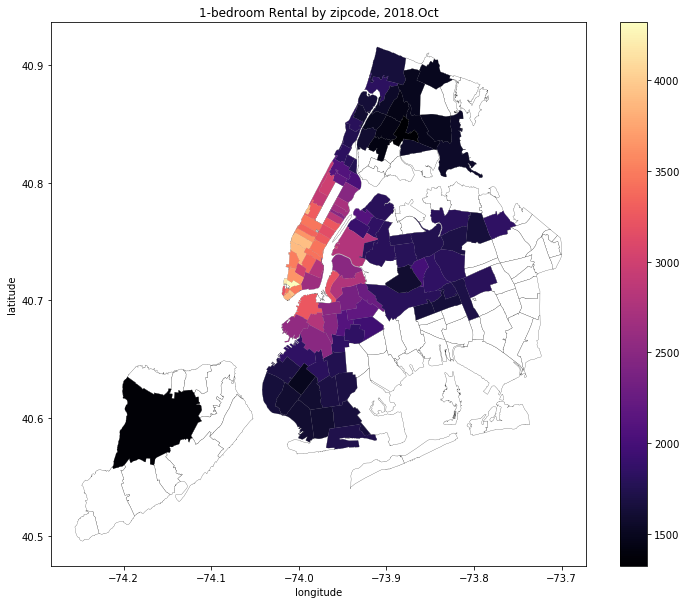

In [24]:
ax = plt.figure(figsize = (12,10)).add_subplot(111)
rental_byzip = rental_byzip.to_crs(epsg=4326)

zipcode = zipcode.to_crs(epsg=4326)
zipcode.plot(color='white', edgecolor='black', ax=ax, lw=0.2, legend = 'True')

rental_byzip.plot(column = 'rent', ax=ax, cmap = 'magma', legend = 'True')
ax.set_title("1-bedroom Rental by zipcode, 2018.Oct")

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()


Figure 1. This is a choropleth map that shows 1-bedroom rental price in New York City. The data is not complete, however, in this project, since we mainly focus on the apartment hunting for NYU CUSP students and not many student will willing to live 2hr driving away from campus, this dataset will still work.

In [25]:
rental_byzip = rental_byzip.sort_values(by='ZIPCODE',ascending=True)


In [26]:
retail["Zip Code"] = retail["Zip Code"].astype(int)
retail_group = retail.groupby("Zip Code").count().reset_index()
retail_byzip = zipcode.merge(retail_group, right_on='Zip Code', left_on='ZIPCODE')
retail_byzip['retail_sqml'] = retail_byzip['County'] / (retail_byzip['AREA'] * 3.587e-8)

#remove the extre values to get more feature characters
retail_byzip = retail_byzip[retail_byzip['retail_sqml'] < 300]

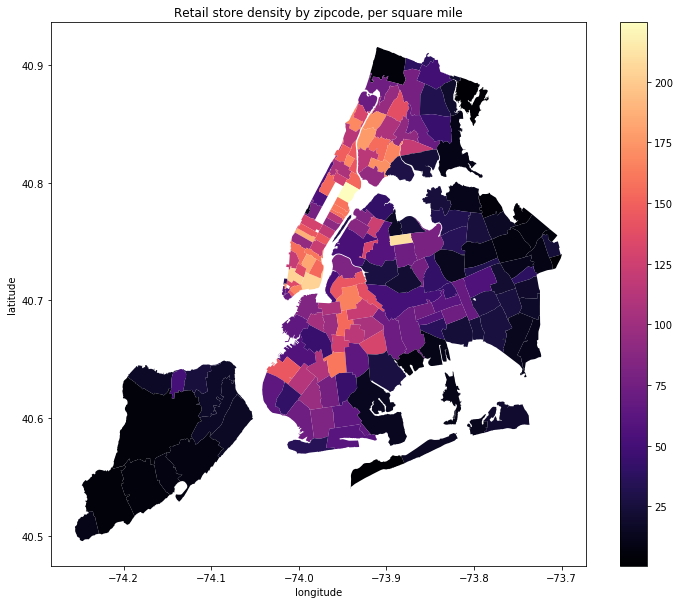

In [27]:
ax = plt.figure(figsize = (12,10)).add_subplot(111)
retail_byzip = retail_byzip.to_crs(epsg=4326)

retail_byzip.plot(column = 'retail_sqml', ax=ax, cmap = 'magma', legend = 'True')
ax.set_title("Retail store density by zipcode, per square mile")

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

Figure 2. This is a choropleth map that shows the retail store density(per square mile) by zipcode. I removed the value over 300 to show more characters of the distribuiton.

### Heatmap

In [28]:
#Heatmap
#function code from http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434


def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()

### For noise

In [29]:
#WGS84
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in 
            zip(noise['Longitude'], noise['Latitude'])]
noise = gpd.GeoDataFrame(noise, crs=crs, geometry = geometry)
noise.dropna(inplace=True)
noise.head()

,Created Date,Latitude,Longitude,geometry
1,06/26/2017 01:54:00 PM,40.631173,-74.100855,POINT (-74.10085491960841 40.6311734893435)
2,07/06/2017 01:56:00 AM,40.769742,-73.982119,POINT (-73.98211853696071 40.76974190486236)
4,08/18/2017 12:21:00 PM,40.814894,-73.944014,POINT (-73.94401432364857 40.81489423515438)
5,09/13/2017 04:59:00 AM,40.707966,-74.013591,POINT (-74.01359073523909 40.70796635945788)
6,09/25/2016 12:35:00 AM,40.880502,-73.922381,POINT (-73.92238094836378 40.88050213569699)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


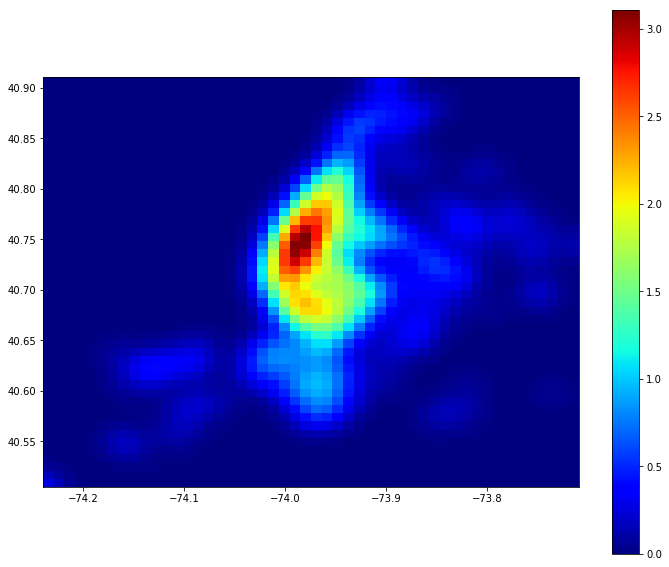

In [30]:
ax = plt.figure(figsize = (12,10)).add_subplot(111)
ax = heatmap(noise, bins=50, smoothing=1.5)

Figure 3. This is a heat map that shows the relative density of noise complaints. As the legend shows, the red the color is, the high the noise level is. We can notice that Manhattan and downtown brooklyn are relative noisy areas.

### For crime

In [31]:
geometry = [Point(xy) for xy in 
            zip(crime['Longitude'], crime['Latitude'])]
crime = gpd.GeoDataFrame(crime, crs=crs, geometry = geometry)
crime.dropna(inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


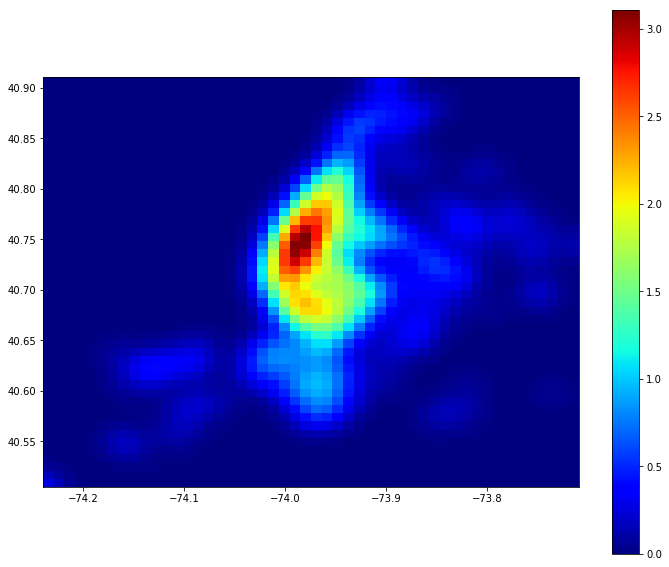

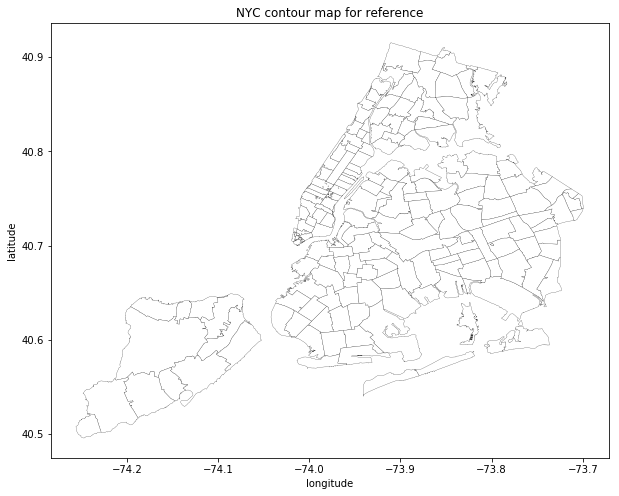

In [32]:
ax = plt.figure(figsize = (12,10)).add_subplot(111)
ax = heatmap(noise, bins=50, smoothing=1.5)


ax2 = plt.figure(figsize = (10,8)).add_subplot(111)
zipcode.plot(color='white', edgecolor='black', ax=ax2, lw=0.2, legend = 'True')

plt.title("NYC contour map for reference")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()



Figure 4. This is a heat map that shows crime location. We can see the downtown Manhattan and downtown brooklyn are two major hotspot that have most crime implemented. The lower one is a zipcode map for relative location reference.

# spatial joins, buffers and the last step before analysis

#### ideas from http://nbviewer.jupyter.org/github/geopandas/geopandas/blob/master/examples/overlays.ipynb

## Spatial join
### For noise

In [33]:
#df = df.merge(zipcode,on='ZIPCODE')

In [34]:
zipcode = zipcode.to_crs(epsg=4326)
noise = noise.to_crs(epsg=4326)
noise_sj = gpd.sjoin(zipcode, noise, how="left")[['ZIPCODE','geometry']].groupby("ZIPCODE").count().reset_index()
noise_sj = noise_sj.rename(columns={"geometry":"noise_num"})
noise_sj = noise_sj.merge(zipcode,on='ZIPCODE')
noise_sj['noise_ds'] = noise_sj['noise_num'] / (noise_sj['AREA'] * 3.587e-8)

In [35]:
noise_sj.head()

,ZIPCODE,noise_num,POPULATION,AREA,geometry,noise_ds
0,83,1,25.0,3.830099e+07,POLYGON ((-73.94922045723267 40.79690954939695...,0.727878
1,10001,120,22413.0,1.779494e+07,POLYGON ((-74.00827017706987 40.75258680959693...,187.998040
2,10002,41,81305.0,2.628013e+07,POLYGON ((-73.97441674502171 40.73642408546694...,43.493564
3,10003,69,55878.0,1.553838e+07,POLYGON ((-73.97986374206835 40.73497413255046...,123.797559
4,10004,20,2187.0,4.002521e+06,POLYGON ((-74.01101005119982 40.70621840523222...,139.304450


### For crime

In [36]:
crime = crime.to_crs(epsg=4326)
crime_sj = gpd.sjoin(zipcode, crime, how="left")[['ZIPCODE','geometry']].groupby("ZIPCODE").count().reset_index()
crime_sj = crime_sj.rename(columns={"geometry":"crime_num"})
crime_sj = crime_sj.merge(zipcode,on='ZIPCODE')
crime_sj['crime_ds'] = crime_sj['crime_num'] / (crime_sj['AREA'] * 3.587e-8)

In [37]:
crime_sj.head()

,ZIPCODE,crime_num,POPULATION,AREA,geometry,crime_ds
0,83,233,25.0,3.830099e+07,POLYGON ((-73.94922045723267 40.79690954939695...,169.595584
1,10001,2972,22413.0,1.779494e+07,POLYGON ((-74.00827017706987 40.75258680959693...,4656.084802
2,10002,2585,81305.0,2.628013e+07,POLYGON ((-73.97441674502171 40.73642408546694...,2742.216159
3,10003,2174,55878.0,1.553838e+07,POLYGON ((-73.97986374206835 40.73497413255046...,3900.520180
4,10004,310,2187.0,4.002521e+06,POLYGON ((-74.01101005119982 40.70621840523222...,2159.218972


In [38]:
#get the zipcode that each bus station is belong to 
bus = bus.to_crs(epsg=4326)
bus_sj = gpd.sjoin(zipcode, bus, how="right")[['ZIPCODE','geometry','asset_id']].reset_index()
bus_sj.head()

,index_right,ZIPCODE,geometry,asset_id
0,2554,11436.0,POINT (-73.80154299999998 40.68396000000007),2555.0
1,2553,11436.0,POINT (-73.80132399999997 40.68411900000007),2554.0
2,3003,11436.0,POINT (-73.79579099999995 40.67353400000007),3004.0
3,2767,11436.0,POINT (-73.79088399999995 40.67353600000007),2768.0
4,3002,11436.0,POINT (-73.79589999999996 40.67375700000008),3003.0


In [39]:
#get the zipcode that each metro station is belong to 
metro = metro.to_crs(epsg=4326)
metro_sj = gpd.sjoin(zipcode, metro, how="right")[['ZIPCODE','geometry','line','name']].reset_index()
metro_sj.head()

,index_right,ZIPCODE,geometry,line,name
0,725,11213.0,POINT (-73.9317019994826 40.66870000130495),3-4,Utica Ave & Eastern Pkwy at SE corner
1,727,11213.0,POINT (-73.93188300008327 40.66870800073886),3-4,Utica Ave & Eastern Pkwy at SW corner
2,724,11213.0,POINT (-73.93183099941535 40.66893500078372),3-4,Utica Ave & Eastern Pkwy at SE corner
3,726,11213.0,POINT (-73.93167500025572 40.66896000111367),3-4,Utica Ave & Eastern Pkwy at NW corner
4,728,11213.0,POINT (-73.93187399954088 40.66896900091607),3-4,Utica Ave & Eastern Pkwy at NW corner


### Prepare the df, gather all the data from spatial join

In [54]:
df = pd.DataFrame()
df['ZIPCODE'] = crime_sj['ZIPCODE'].astype(int)
df['area'] = crime_sj['AREA']
df['noise_ds'] = noise_sj['noise_ds']
df['crime_ds'] = crime_sj['crime_ds']

In [55]:
retail_byzip = retail_byzip[['ZIPCODE','retail_sqml']]
retail_byzip = retail_byzip.groupby(retail_byzip['ZIPCODE']).sum().reset_index()

In [56]:
df = df.merge(retail_byzip, on='ZIPCODE')

In [57]:
df.head()

,ZIPCODE,area,noise_ds,crime_ds,retail_sqml
0,10001,1.779494e+07,187.998040,4656.084802,93.999020
1,10002,2.628013e+07,43.493564,2742.216159,203.677177
2,10003,1.553838e+07,123.797559,3900.520180,183.005087
3,10004,4.002521e+06,139.304450,2159.218972,69.652225
4,10005,2.082901e+06,281.073085,3172.110529,147.228759


## Buffers
### For bus station

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


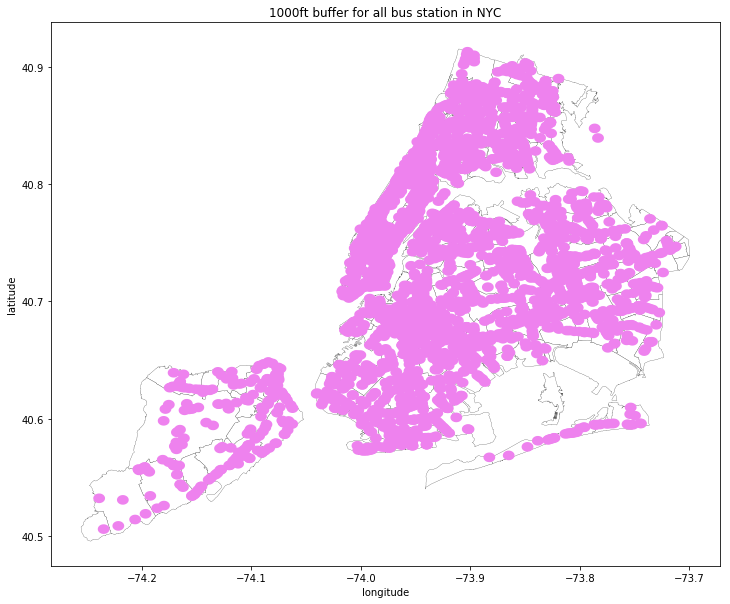

In [58]:
# 1. buffer for bus station
# radius = 1500 ft which is roughly 5 minute walk
bus_sj = bus_sj.to_crs(epsg=3359)
res = bus_sj.buffer(1500)
res = pd.DataFrame(res)
res.head()

bus_buffer = bus_sj[['asset_id','ZIPCODE']]
bus_buffer['buffer'] = res[0]
crs = {'init': 'epsg:3359'}
bus_buffer = gpd.GeoDataFrame(bus_buffer,crs=crs,geometry=res[0])

#plot
ax = plt.figure(figsize = (12,10)).add_subplot(111)

zipcode.plot(color='white', edgecolor='black', ax=ax, lw=0.2, legend = 'True')

bus_buffer = bus_buffer.to_crs(epsg=4326)
bus_buffer.plot(ax = ax,color='violet')

plt.title("1000ft buffer for all bus station in NYC")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()


Figure 3. This is a map that shows 1000ft buffer of bus stations in New York City.

In [59]:
bus_bf_byzip = bus_buffer[['ZIPCODE','asset_id','buffer']]
crs = {'init': 'epsg:3359'}
bus_bf_byzip = gpd.GeoDataFrame(bus_bf_byzip, crs=crs, geometry = bus_bf_byzip['buffer'])

#all the buffer sizes are the same, so we actually use the first area to calculate
bus_bf_byzip['area'] = bus_bf_byzip['buffer'][0].area

bus_bf_byzip = bus_bf_byzip.groupby("ZIPCODE").sum().reset_index()
bus_bf_byzip.head()


,ZIPCODE,asset_id,area
0,10001.0,34727.0,1.270302e+08
1,10002.0,57698.0,2.328887e+08
2,10003.0,25981.0,1.058585e+08
3,10004.0,4933.0,2.117170e+07
4,10005.0,3086.0,1.411447e+07


In [60]:
df = df.merge(bus_bf_byzip, on='ZIPCODE').drop(columns=['asset_id'])

In [61]:
df['bus_bf_pct'] = (df['area_y'] / df['area_x']) * 100
df.head()

,ZIPCODE,area_x,noise_ds,crime_ds,retail_sqml,area_y,bus_bf_pct
0,10001,1.779494e+07,187.998040,4656.084802,93.999020,1.270302e+08,713.855783
1,10002,2.628013e+07,43.493564,2742.216159,203.677177,2.328887e+08,886.178030
2,10003,1.553838e+07,123.797559,3900.520180,183.005087,1.058585e+08,681.271387
3,10004,4.002521e+06,139.304450,2159.218972,69.652225,2.117170e+07,528.959168
4,10005,2.082901e+06,281.073085,3172.110529,147.228759,1.411447e+07,677.635051


### For metro station

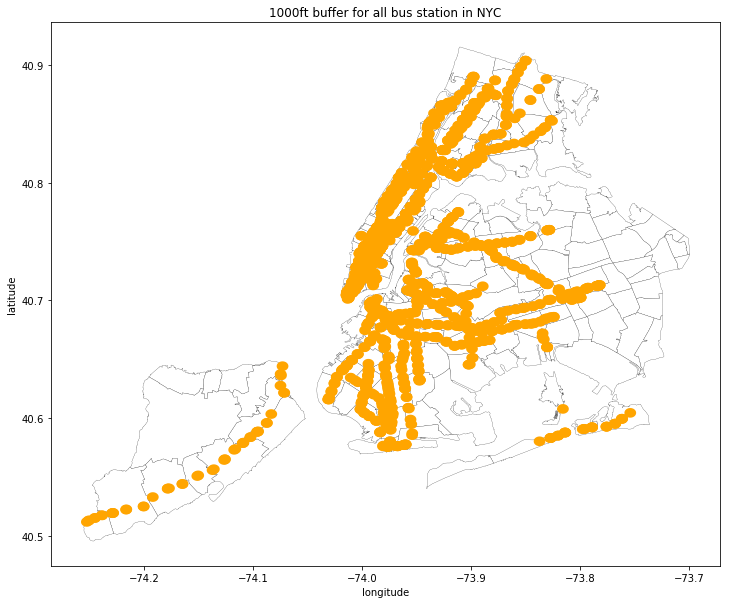

In [62]:
# # 2. buffer for metro station
# radius = 1500 ft which is roughly a 5 minture walk
metro_sj = metro_sj.to_crs(epsg=3359)
res = metro_sj.buffer(1500)
res = pd.DataFrame(res)
metro_buffer = metro_sj[['line','name','ZIPCODE']]
crs = {'init': 'epsg:3359'}
metro_buffer = gpd.GeoDataFrame(metro_buffer,crs=crs,geometry=res[0])




#plot
ax = plt.figure(figsize = (12,10)).add_subplot(111)
zipcode.plot(color='white', edgecolor='black', ax=ax, lw=0.2, legend = 'True')
metro_buffer = metro_buffer.to_crs(epsg=4326)
metro_buffer.plot(ax = ax,color='orange')

plt.title("1000ft buffer for all bus station in NYC")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()



Figure 4. This is the buffer map for metro station in NYC. The radius of the buffer is 1500ft which is roughly a 5 minute walk.

In [63]:
metro_bf_byzip = metro_buffer
crs = {'init': 'epsg:4326'}
metro_bf_byzip = gpd.GeoDataFrame(metro_buffer, crs=crs, geometry = metro_bf_byzip['geometry'])
metro_bf_byzip = metro_bf_byzip.to_crs(epsg=3359)

'''the metro_buffer have the geometry in lat-long, so we need to create a geodataframe in 4326, 
and then turn it into 3359. Or you will get a projected geodataframe with lat-long NUMBERS. 
(-73.95.. instead of 3403262) with epsg=3359
'''
#all the buffer sizes are the same, so we actually use the first area to calculate
metro_bf_byzip['area'] = metro_bf_byzip['geometry'][0].area

metro_bf_byzip = metro_bf_byzip.groupby("ZIPCODE").sum().reset_index()

In [64]:
metro_bf_byzip.head()

,ZIPCODE,area
0,83.0,3.528617e+07
1,10001.0,3.528617e+08
2,10002.0,1.199730e+08
3,10003.0,1.976026e+08
4,10004.0,1.411447e+08


In [65]:
df.head()

,ZIPCODE,area_x,noise_ds,crime_ds,retail_sqml,area_y,bus_bf_pct
0,10001,1.779494e+07,187.998040,4656.084802,93.999020,1.270302e+08,713.855783
1,10002,2.628013e+07,43.493564,2742.216159,203.677177,2.328887e+08,886.178030
2,10003,1.553838e+07,123.797559,3900.520180,183.005087,1.058585e+08,681.271387
3,10004,4.002521e+06,139.304450,2159.218972,69.652225,2.117170e+07,528.959168
4,10005,2.082901e+06,281.073085,3172.110529,147.228759,1.411447e+07,677.635051


In [66]:
df = df.merge(metro_bf_byzip, on='ZIPCODE')
df['metro_bf_pct'] = (df['area'] / df['area_x']) * 100

In [69]:
df.head()

,ZIPCODE,area_x,noise_ds,crime_ds,retail_sqml,area_y,bus_bf_pct,area,metro_bf_pct
0,10001,1.779494e+07,187.998040,4656.084802,93.999020,1.270302e+08,713.855783,3.528617e+08,1982.932732
1,10002,2.628013e+07,43.493564,2742.216159,203.677177,2.328887e+08,886.178030,1.199730e+08,456.515955
2,10003,1.553838e+07,123.797559,3900.520180,183.005087,1.058585e+08,681.271387,1.976026e+08,1271.706589
3,10004,4.002521e+06,139.304450,2159.218972,69.652225,2.117170e+07,528.959168,1.411447e+08,3526.394456
4,10005,2.082901e+06,281.073085,3172.110529,147.228759,1.411447e+07,677.635051,9.880128e+07,4743.445357


In [70]:
rental.head()

,RegionName,CountyName,2018-10
0,10025,New York County,2995.0
2,10023,New York County,3300.0
6,10002,New York County,2637.5
7,10467,Bronx County,1500.0
10,11226,Kings County,1750.0


In [71]:
df = df.merge(rental, left_on='ZIPCODE', right_on='RegionName')

In [72]:
df.head()

,ZIPCODE,area_x,noise_ds,crime_ds,retail_sqml,area_y,bus_bf_pct,area,metro_bf_pct,RegionName,CountyName,2018-10
0,10001,1.779494e+07,187.998040,4656.084802,93.999020,1.270302e+08,713.855783,3.528617e+08,1982.932732,10001,New York County,3910.0
1,10002,2.628013e+07,43.493564,2742.216159,203.677177,2.328887e+08,886.178030,1.199730e+08,456.515955,10002,New York County,2637.5
2,10003,1.553838e+07,123.797559,3900.520180,183.005087,1.058585e+08,681.271387,1.976026e+08,1271.706589,10003,New York County,3350.0
3,10004,4.002521e+06,139.304450,2159.218972,69.652225,2.117170e+07,528.959168,1.411447e+08,3526.394456,10004,New York County,3837.5
4,10005,2.082901e+06,281.073085,3172.110529,147.228759,1.411447e+07,677.635051,9.880128e+07,4743.445357,10005,New York County,3930.0


In [75]:
df = df[['ZIPCODE', 'area_x', 'noise_ds', 'crime_ds', 'retail_sqml',
       'bus_bf_pct', 'metro_bf_pct', '2018-10']]
df = df.rename(columns={"2018-10":"rent", "area_x":"area"})

In [77]:
df.head()

,ZIPCODE,area,noise_ds,crime_ds,retail_sqml,bus_bf_pct,metro_bf_pct,rent
0,10001,1.779494e+07,187.998040,4656.084802,93.999020,713.855783,1982.932732,3910.0
1,10002,2.628013e+07,43.493564,2742.216159,203.677177,886.178030,456.515955,2637.5
2,10003,1.553838e+07,123.797559,3900.520180,183.005087,681.271387,1271.706589,3350.0
3,10004,4.002521e+06,139.304450,2159.218972,69.652225,528.959168,3526.394456,3837.5
4,10005,2.082901e+06,281.073085,3172.110529,147.228759,677.635051,4743.445357,3930.0


## Analysis

### scatter matrix

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


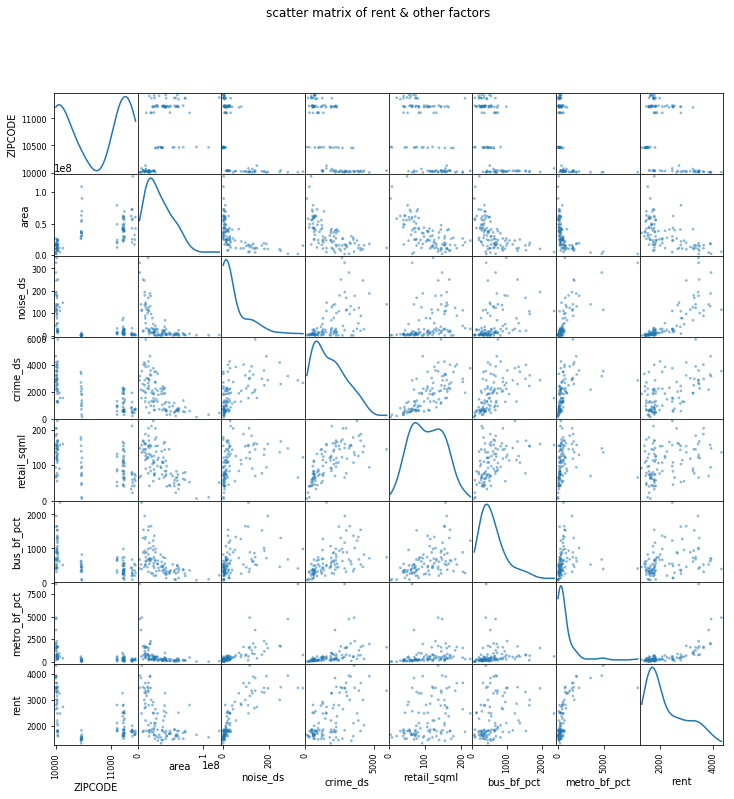

In [80]:
sfig = pd.scatter_matrix(df, s=30, figsize=(12, 12), diagonal='kde')
plt.suptitle('scatter matrix of rent & other factors')
plt.show()

Figure 5. This is a scatter matrix of the rent(per zipcode), metro buffer ratio(metro 1500ft buffer over area per zipcode), bus buffer ratio(bus 1500ft buffer over area per zipcode), retail store density(per square mile),crime density(per square mile per zipcode), noise complaint density(per square mile per zipcode), and area. We can see that there are some correlation between rent vs. noise/metro pct

### Statistical test

#### KS test

In [84]:
# statistical significance threshold
alpha = 0.05

ksTips = sp.stats.kstest((df.rent - df.rent.mean()) / df.rent.std(), "norm")
verb = "does not " if ksTips[1] < alpha else "does "
print ("The distribution of rent " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the KS test")

The distribution of rent does not follow a normal distribution (p < 0.05) according to the KS test


#### AD test

In [85]:
adTips = sp.stats.anderson((df.rent - df.rent.mean()) / df.rent.std(), "norm")
verb = "does not " if adTips[0] > adTips[1][adTips[2] == alpha * 100] else "does "
print ("The distribution of rent " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the AD test")

The distribution of rent does not follow a normal distribution (p < 0.05) according to the AD test


#### pearsonr test: (Pearson’s correlation coefficient, 2-tailed p-value)

In [83]:
sp.stats.pearsonr(df.rent,df.noise_ds)

(0.81416693802359086, 1.3796960116650893e-25)

In [86]:
sp.stats.pearsonr(df.rent,df.metro_bf_pct)

(0.66165837613808565, 2.7708875646880221e-14)

## modelling & plotting

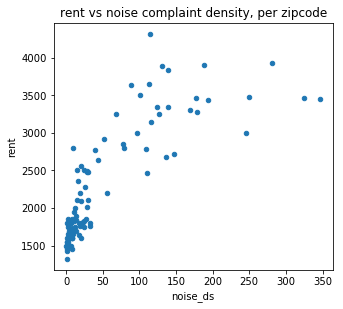

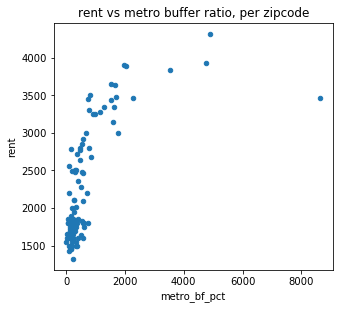

In [104]:
#see the scatter plot first
ax1 = plt.figure(figsize = (5,10)).add_subplot(211)
ax2 = plt.figure(figsize = (5,10)).add_subplot(212)
df.plot.scatter(y='rent',x='noise_ds',ax=ax1)
ax1.set_title("rent vs noise complaint density, per zipcode")


df.plot.scatter(y='rent',x='metro_bf_pct',ax=ax2)
ax2.set_title("rent vs metro buffer ratio, per zipcode")

plt.show()

Figure 6. This is a scatter plot that shows rent vs 
noise complaint density per zipcode. Might not be a 
simple linear relationship, but I will try that first

In [108]:
ols1 = smf.ols(formula='rent ~ noise_ds', data=df).fit()
ols2 = smf.ols(formula='rent ~ metro_bf_pct', data=df).fit()
print(ols1.summary())
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     198.6
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           1.38e-25
Time:                        21:50:28   Log-Likelihood:                -772.75
No. Observations:                 103   AIC:                             1550.
Df Residuals:                     101   BIC:                             1555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1827.0068     53.381     34.226      0.0

#### Both factors showed some positive correlation with the rent (R2_1 = 0.663 and  R2_2 = 0.438), however they are not very strong. I will then test on the modified linear regression. 

### multivariate model

In [110]:
ols3 = smf.ols(formula='rent ~ noise_ds + metro_bf_pct', data=df).fit()
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     104.4
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           3.33e-25
Time:                        21:54:28   Log-Likelihood:                -770.70
No. Observations:                 103   AIC:                             1547.
Df Residuals:                     100   BIC:                             1555.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1814.3489     52.959     34.259   

#### R2=0.676 this time, seems better, let's try semi-log scale one

### Semi-log scale model

In [114]:
df['log_noise'] = np.log(df['noise_ds'])
df['log_metro_bf_pct'] = np.log(df['metro_bf_pct'])
ols4 = smf.ols(formula='rent ~ log_noise + log_metro_bf_pct', data=df).fit()
print(ols4.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     161.1
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           5.36e-32
Time:                        21:57:33   Log-Likelihood:                -754.59
No. Observations:                 103   AIC:                             1515.
Df Residuals:                     100   BIC:                             1523.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          295.1484    218.028  

#### R2 is 0.763 this time. We can say that this model works better for the rent ~ log_noise + log_metro_bf_pct relationship